In [1]:
import os, cupy as cp, subprocess
print("CUDA_PATH:", os.environ.get("CUDA_PATH"))
print("LD_LIBRARY_PATH:", os.environ.get("LD_LIBRARY_PATH"))
print("nvcc:", subprocess.check_output(["which","nvcc"]).decode().strip())
print(subprocess.check_output(["nvcc","--version"]).decode().splitlines()[-1])
print("Device count:", cp.cuda.runtime.getDeviceCount())


CUDA_PATH: /usr/local/cuda
LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
nvcc: /home/user/miniconda/envs/rapids/bin/nvcc
Build cuda_12.9.r12.9/compiler.36037853_0
Device count: 1


/home/user/miniconda/envs/rapids/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi  # check GPU

Tue Nov 11 00:15:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     On  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              2W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import cupy as cp
import numpy as np
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import r2_score
from sklearn.model_selection import KFold
import optuna
import pandas as pd
import gc

In [ ]:
data = pd.read_excel('Final_Data 5.xlsx', engine='openpyxl')

In [5]:
x = data.drop(['time', 'latitude', 'longitude', 'Abr', 'PM2.5'], axis=1)
#x = x.drop('Stations', axis=1)
#x = x.drop('longitude_c', axis=1)
#x = x.drop('latitude_c', axis=1)
y = data['PM2.5']

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(x))  # store all (train_idx, val_idx) pairs

# Modify folds to also store the original validation indices
folds = [(cp.asarray(x.iloc[tr]), cp.asarray(x.iloc[val]), cp.asarray(y.iloc[tr]), cp.asarray(y.iloc[val]), val) for tr, val in splits]
del kf, splits

In [7]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 40),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0), # Changed from categorical to float
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
    }

    r2s = []

    for x_train, x_val, y_train, y_val, indices in folds:

        model = RandomForestRegressor(**params)
        # Removed the RFContext block
        model.fit(x_train, y_train)
        preds = model.predict(x_val)
        r2 = r2_score(y_val, preds)
        r2s.append(r2)  # move to CPU for mean()
        del model, preds, r2, x_train, x_val, y_train, y_val
        cp.get_default_memory_pool().free_all_blocks()  # free cuPy GPU memory
        gc.collect()  # free Python RAM

    cp.get_default_memory_pool().free_all_blocks()  # free cuPy GPU memory
    gc.collect()  # free Python RAM



    return np.mean(r2s)

In [50]:
study = optuna.create_study(
    direction="maximize",
    study_name="RandomForest_Tuning",
    storage=f"sqlite:///rf_tuning.db" ,# <-- saves study to file
    load_if_exists=True
)


[I 2025-11-11 00:36:10,825] Using an existing study with name 'RandomForest_Tuning' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=5)  # Adjust n_trials as needed

In [53]:
best_params = study.best_params

In [54]:
best_params

{'n_estimators': 406,
 'max_depth': 33,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 0.10350217444283559,
 'bootstrap': False}

In [17]:
best_params = {'n_estimators': 406,
                'max_depth': 33,
                'min_samples_split': 6,
                'min_samples_leaf': 1,
                'max_features': 0.10350217444283559,
                'bootstrap': False}

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [19]:
# K-Fold cross-validation setup
val_losses = []
tr = []
val = []
pred_tr = []
pred_val = []
val_original_indices = [] # New list to store original validation indices

# Unpack val_indices from folds
for x_train, x_val, y_train, y_val, val_indices in folds:

    # Train the RandomForestRegressor model with GPU support
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(x_train, y_train)

    # Predict on validation and training sets
    preds_val_cp = model.predict(x_val)
    preds_tr_cp = model.predict(x_train)

    # Convert CuPy arrays to NumPy arrays for sklearn metrics and plotting
    y_val_np = y_val.get()
    preds_val_np = preds_val_cp.get()
    y_train_np = y_train.get()
    preds_tr_np = preds_tr_cp.get()

    # Evaluate the model on the validation set
    rmse = np.sqrt(mean_squared_error(y_val_np, preds_val_np))
    mae = mean_absolute_error(y_val_np, preds_val_np)
    r2 = r2_score(y_val_np, preds_val_np)
    val_losses.append([rmse, mae, r2])

    # Store NumPy arrays for plotting and original indices
    tr.append(y_train_np)
    val.append(y_val_np)
    pred_tr.append(preds_tr_np)
    pred_val.append(preds_val_np)
    val_original_indices.append(val_indices) # Store original indices

    # Free CuPy GPU memory and Python RAM
    del model, preds_val_cp, preds_tr_cp, y_val_np, preds_val_np, y_train_np, preds_tr_np
    cp.get_default_memory_pool().free_all_blocks()
    gc.collect()

In [20]:
def avg_list_elements(list, id):
    c = 0
    for i in range(len(list)):
        c += list[i][id]
    return c/len(list)

In [21]:
print(f'avg rmse: {avg_list_elements(val_losses, 0):.5f}')
print(f'avg mae: {avg_list_elements(val_losses, 1):.5f}')
print(f'avg r2: {avg_list_elements(val_losses, 2):.5f}')

avg rmse: 6.17446
avg mae: 4.46939
avg r2: 0.79438


In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

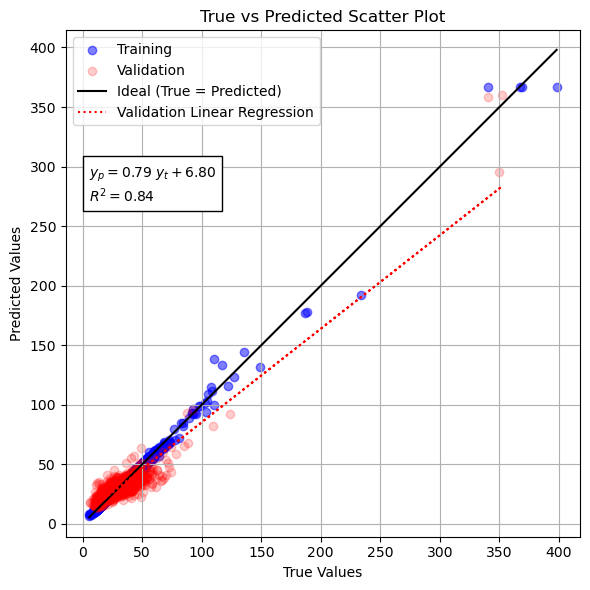

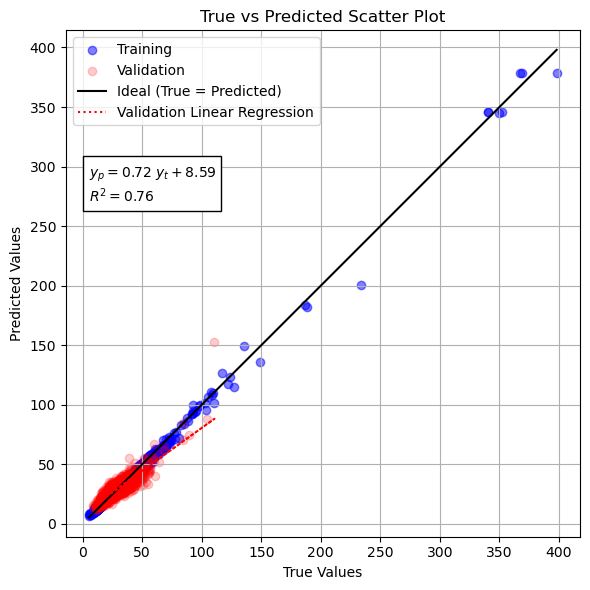

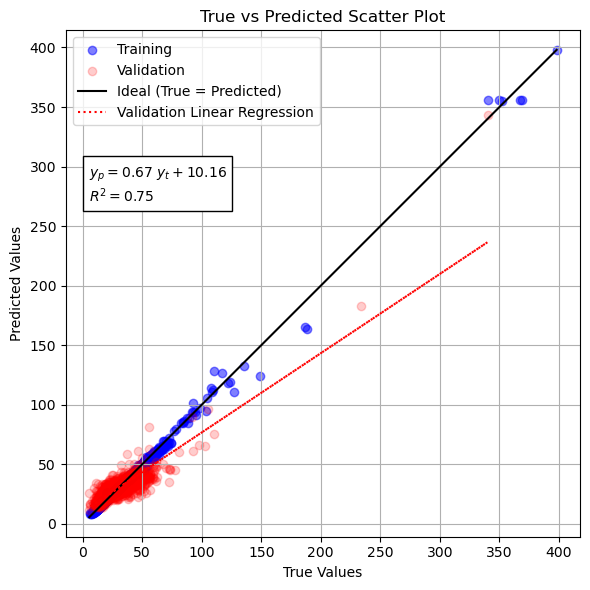

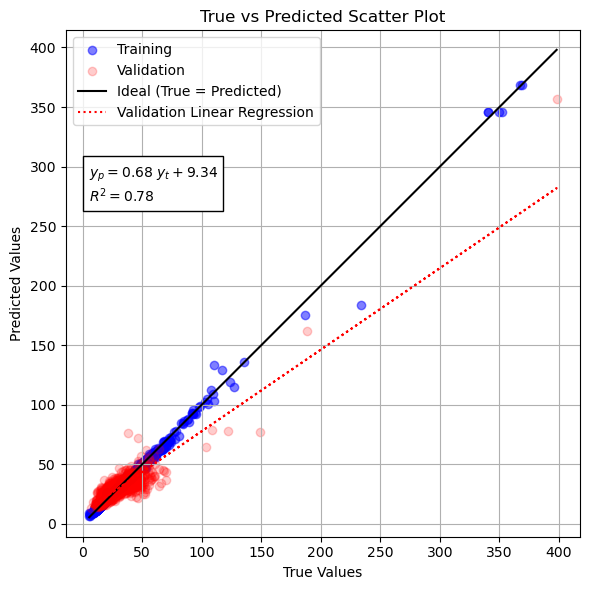

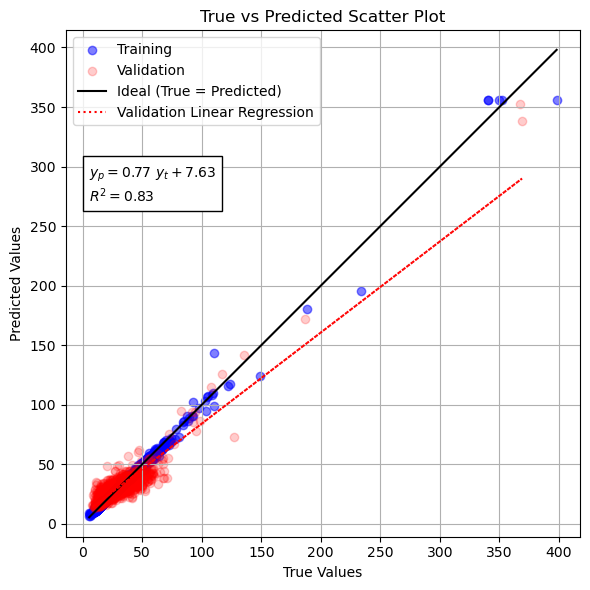

In [23]:
for i in range(len(tr)):
    plt.figure(figsize=(6, 6))
    plt.scatter(tr[i], pred_tr[i], color='blue', label='Training', alpha=0.5)
    plt.scatter(val[i], pred_val[i], color='r', label='Validation', alpha=0.2)

    min_1 = min(min(tr[i]), min(val[i]))
    min_2 = min(min(pred_tr[i]), min(pred_val[i]))
    minn = min(min_1, min_2)
    max_1 = max(max(tr[i]), max(val[i]))
    max_2 = max(max(pred_tr[i]), max(pred_val[i]))
    maxx = max(max_1, max_2)

    plt.plot([minn, maxx], [minn, maxx], color='k', linestyle='-', label='Ideal (True = Predicted)')

    model = LinearRegression()
    model.fit(np.array(val[i]).reshape((-1,1)), np.array(pred_val[i]).reshape((-1,1)))
    y_pred = model.predict(np.array(val[i]).reshape((-1,1)))
    r2 = r2_score(np.array(val[i]).reshape((-1,1)), np.array(pred_val[i]).reshape((-1,1)))

    # Coefficients
    slope = model.coef_[0]
    intercept = model.intercept_

    # Equation text
    eq_text = f"$y_p = {slope[0]:.2f}\ y_t + {intercept[0]:.2f}$\n$R^2 = {r2:.2f}$"

    plt.plot(val[i], y_pred, color='r', linestyle=':', label='Validation Linear Regression')
    plt.text(x=5, y=270, s=eq_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))

    #plt.text(5, 380, f'RMSE: {val_losses[i][0]:.2f}', size=12)
    #plt.text(5, 360, f'MAE: {val_losses[i][1]:.2f}', size=12)
    #plt.text(5, 340, f'$R^2$: {val_losses[i][2]:.2f}', size=12)

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Makes the diagonal line at 45 degrees
    plt.tight_layout()
    plt.show()

In [24]:
df = []
for i in range(len(val)):
    # Use the stored original validation indices to create the Pandas Series index
    df.append(pd.Series(data=pred_val[i], index=data.index[val_original_indices[i]], name='Pred_PM2.5'))

In [25]:
dff = []
for i in range(len(df)):
    dff.append(pd.concat([data[['time', 'Abr', 'PM2.5']], df[i]], axis=1, join='inner'))

In [28]:
pd.concat(dff).to_excel("5F CV.xlsx")

In [34]:
# Simulate your DataFrame (replace this with your actual data)
# Assume `df` is your DataFrame and it has a column 'Station' representing station IDs
# df = pd.read_csv(...)  # Your actual data here

# Example: Let's assume your column is named 'Station'
def get_leave_station_out_folds(df, station_col='Stations', n_folds=5, min_val_fraction=0.1, random_state=42):
    np.random.seed(random_state)

    # Count samples per station
    station_sizes = df[station_col].value_counts()
    total_size = len(df)

    # Shuffle station list for randomness
    stations = station_sizes.index.tolist()
    np.random.shuffle(stations)

    folds = []
    used_stations = set()

    for _ in range(n_folds):
        val_stations = []
        val_count = 0

        # Keep selecting stations until val set has enough data
        for st in stations:
            if st in used_stations:
                continue
            val_stations.append(st)
            val_count += station_sizes[st]
            if val_count / total_size >= min_val_fraction:
                break

        used_stations.update(val_stations)

        val_mask = df[station_col].isin(val_stations)
        train_mask = ~val_mask

        train_df = df[train_mask].copy()
        val_df = df[val_mask].copy()

        x_train = cp.asarray(train_df.drop(['time', 'latitude', 'longitude', 'PM2.5', 'Abr'], axis=1))
        y_train = cp.asarray(train_df['PM2.5'])
        x_valid = cp.asarray(val_df.drop(['time', 'latitude', 'longitude', 'PM2.5', 'Abr'], axis=1))
        y_valid = cp.asarray(val_df['PM2.5'])

        folds.append((x_train, x_valid, y_train, y_valid, val_df.index))

        # If all stations used, reinitialize (optional if you want reused stations)
        if len(used_stations) == len(station_sizes):
            used_stations = set()
            np.random.shuffle(stations)

    return folds


In [35]:
folds = get_leave_station_out_folds(data, station_col='Abr', n_folds=7, random_state=42)

In [36]:
# K-Fold cross-validation setup
val_losses = []
tr = []
val = []
pred_tr = []
pred_val = []
val_original_indices = [] # New list to store original validation indices

# Unpack val_indices from folds
for x_train, x_val, y_train, y_val, val_indices in folds:

    # Train the RandomForestRegressor model with GPU support
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(x_train, y_train)

    # Predict on validation and training sets
    preds_val_cp = model.predict(x_val)
    preds_tr_cp = model.predict(x_train)

    # Convert CuPy arrays to NumPy arrays for sklearn metrics and plotting
    y_val_np = y_val.get()
    preds_val_np = preds_val_cp.get()
    y_train_np = y_train.get()
    preds_tr_np = preds_tr_cp.get()

    # Evaluate the model on the validation set
    rmse = np.sqrt(mean_squared_error(y_val_np, preds_val_np))
    mae = mean_absolute_error(y_val_np, preds_val_np)
    r2 = r2_score(y_val_np, preds_val_np)
    val_losses.append([rmse, mae, r2])

    # Store NumPy arrays for plotting and original indices
    tr.append(y_train_np)
    val.append(y_val_np)
    pred_tr.append(preds_tr_np)
    pred_val.append(preds_val_np)
    val_original_indices.append(val_indices) # Store original indices

    # Free CuPy GPU memory and Python RAM
    del model, preds_val_cp, preds_tr_cp, y_val_np, preds_val_np, y_train_np, preds_tr_np
    cp.get_default_memory_pool().free_all_blocks()
    gc.collect()


In [37]:
val_losses

[[np.float64(4.893274078244909), 3.694035127887369, 0.812955931840296],
 [np.float64(8.33656904541739), 6.650903447487411, 0.6807599560219046],
 [np.float64(7.811073436587891), 6.409444895008383, 0.7571419122402369],
 [np.float64(8.046818241585415), 5.402837330986138, 0.6645598591954893],
 [np.float64(6.792079510178171), 5.351425444081813, 0.7274588965780748],
 [np.float64(6.611319566319231), 4.739612449065984, 0.7381970552675994],
 [np.float64(8.073231746002621), 6.258340987879601, 0.7328585690131452]]

In [38]:
print(f'avg rmse: {avg_list_elements(val_losses, 0):.5f}')
print(f'avg mae: {avg_list_elements(val_losses, 1):.5f}')
print(f'avg r2: {avg_list_elements(val_losses, 2):.5f}')

avg rmse: 7.22348
avg mae: 5.50094
avg r2: 0.73056


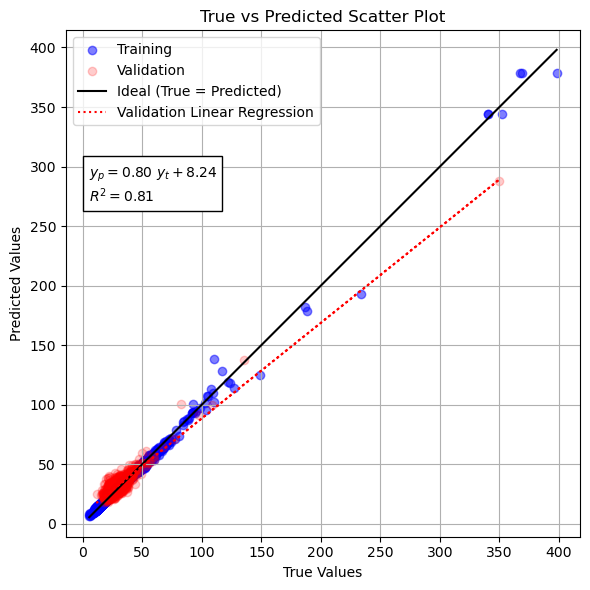

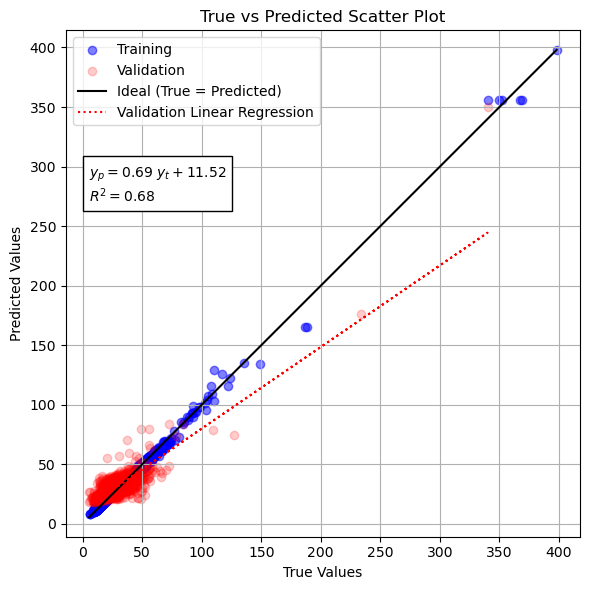

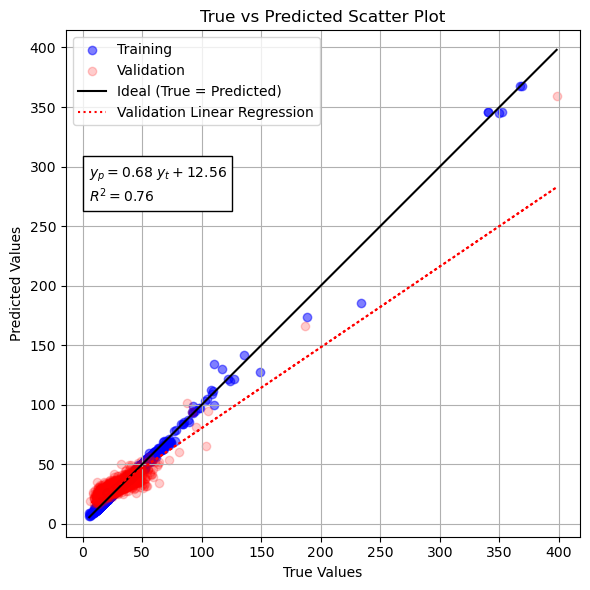

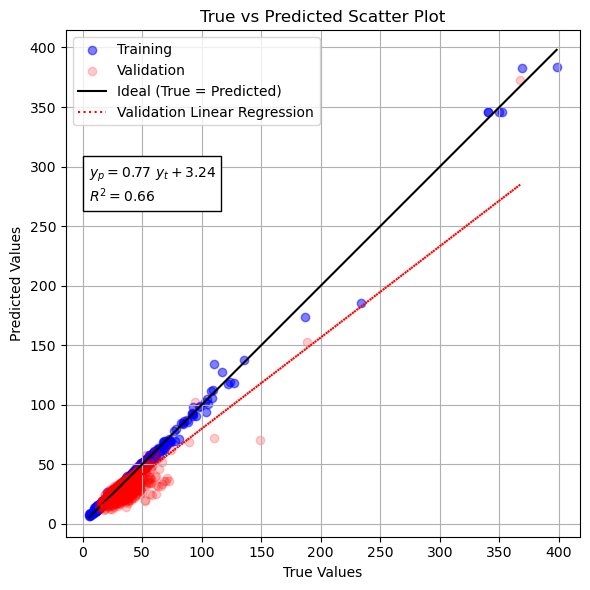

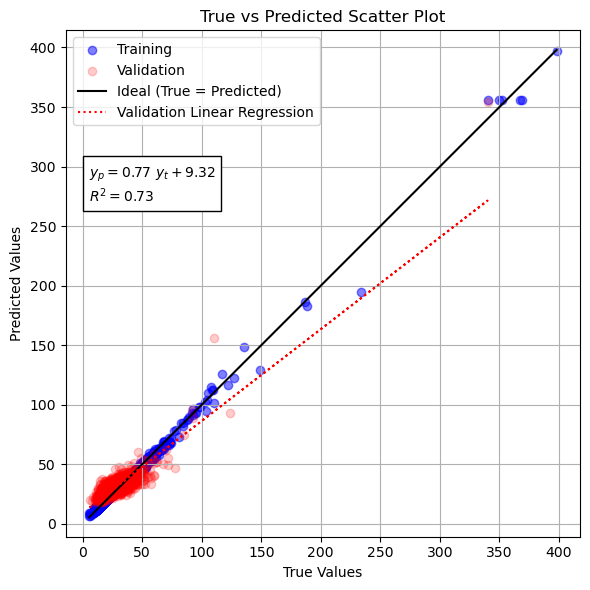

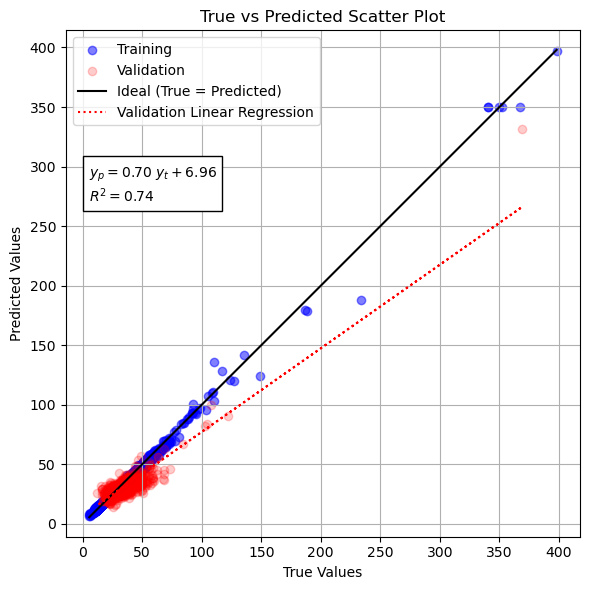

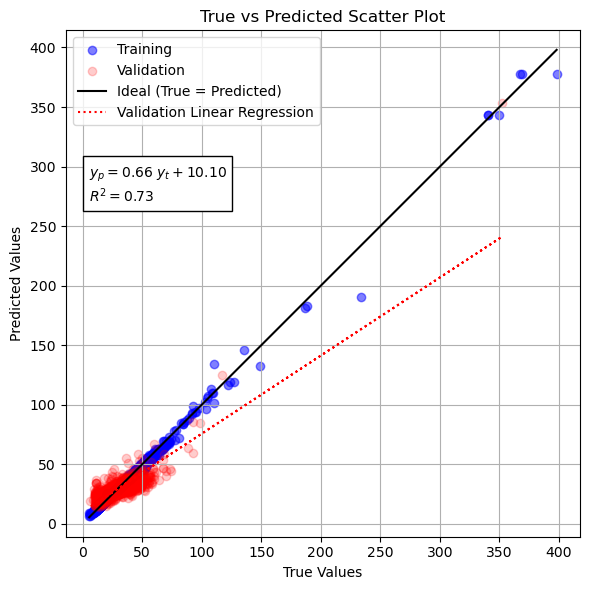

In [39]:
for i in range(len(tr)):
    plt.figure(figsize=(6, 6))
    plt.scatter(tr[i], pred_tr[i], color='blue', label='Training', alpha=0.5)
    plt.scatter(val[i], pred_val[i], color='r', label='Validation', alpha=0.2)

    min_1 = min(min(tr[i]), min(val[i]))
    min_2 = min(min(pred_tr[i]), min(pred_val[i]))
    minn = min(min_1, min_2)
    max_1 = max(max(tr[i]), max(val[i]))
    max_2 = max(max(pred_tr[i]), max(pred_val[i]))
    maxx = max(max_1, max_2)

    plt.plot([minn, maxx], [minn, maxx], color='k', linestyle='-', label='Ideal (True = Predicted)')

    model = LinearRegression()
    model.fit(np.array(val[i]).reshape((-1,1)), np.array(pred_val[i]).reshape((-1,1)))
    y_pred = model.predict(np.array(val[i]).reshape((-1,1)))
    r2 = r2_score(np.array(val[i]).reshape((-1,1)), np.array(pred_val[i]).reshape((-1,1)))

    # Coefficients
    slope = model.coef_[0]
    intercept = model.intercept_

    # Equation text
    eq_text = f"$y_p = {slope[0]:.2f}\ y_t + {intercept[0]:.2f}$\n$R^2 = {r2:.2f}$"

    plt.plot(val[i], y_pred, color='r', linestyle=':', label='Validation Linear Regression')
    plt.text(x=5, y=270, s=eq_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black'))

    #plt.text(5, 380, f'RMSE: {val_losses[i][0]:.2f}', size=12)
    #plt.text(5, 360, f'MAE: {val_losses[i][1]:.2f}', size=12)
    #plt.text(5, 340, f'$R^2$: {val_losses[i][2]:.2f}', size=12)

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Makes the diagonal line at 45 degrees
    plt.tight_layout()
    plt.show()

In [40]:
df = []
for i in range(len(val)):
    # Use the stored original validation indices to create the Pandas Series index
    df.append(pd.Series(data=pred_val[i], index=data.index[val_original_indices[i]], name='Pred_PM2.5'))

In [41]:
dff = []
for i in range(len(df)):
    dff.append(pd.concat([data[['time', 'Abr', 'PM2.5']], df[i]], axis=1, join='inner'))

In [42]:
pd.concat(dff).to_excel('LOO CV.xlsx')